# ADL HW2 - PCA and Autoencoders
In this assignment you will implement two dimensionality reduction schemes
we saw in class:
1. Principal Component Analysis (PCA)
2. Autoencoder

You will also implement an image denoising model to enhance the performance of a simple MLP classifier.

The data used in the following exercises is a subset of the MNIST dataset.
Randomly sample 10,000 images from MNIST train set (you may set a random.seed).

# Submission Date: 05.01.2025
Submit the already-run notebook.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
from numpy import matmul
from torch.autograd import Variable
import seaborn as sns
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# EX1. PCA dimensionality reduction (10pts)

1. Implement the PCA procedure in the function ```perform_PCA()```.

Useful functions:
```
sklearn.preprocessing.StandardScaler
scipy.linalg.eigh
numpy.matmul
```
The input should be in vector form (i.e., flatten the input images beforehand).

2. Project the data to 2D, i.e, $\mathbb{R}^{784}↦ \mathbb{R}^2$.
3. Scatter plot the data using the 2D projection and class labels. You'll need to implement ```plot_projected_data()```


In [2]:
def perform_PCA(X, n_components):
  X = X.reshape(X.shape[0], -1)
  scaler = StandardScaler()
  X_standardized = scaler.fit_transform(X)
  covariance_matrix = np.cov(X_standardized, rowvar=False)
  eigenvalues, eigenvectors = eigh(covariance_matrix)
  top_indices = np.argsort(eigenvalues)[-n_components:][::-1]
  top_eigenvectors = eigenvectors[:, top_indices]
  X_reduced = np.matmul(X_standardized, top_eigenvectors)

  return X_reduced

  """
  Implement the PCA algorithm.
  Input: X [numpy array] - shape: (N,784)
  Output: Projected data using n_components
  """

def plot_projected_data(X, y, title):
  classes = np.unique(y)
  clrs = sns.color_palette('gist_rainbow', n_colors=10)  # a list of RGB tuples
  for k in classes:

    # Take samples within class
    Xk = X[y==k]
    yk = y[y==k]
    color = clrs[k]
    plt.scatter(Xk[:,0], Xk[:,1], color=color, label=k)
  plt.legend()
  plt.title(title)
  plt.grid()

In [3]:
# For EX5, Please use the (0.5, 0.5) normalization value, as
# they were used for training the MLP
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.77MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



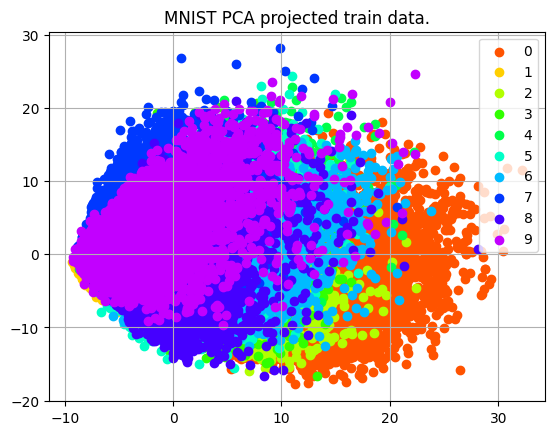

In [4]:
### Your code goes here ###
X_reduced = perform_PCA(train_subset.dataset.data.numpy(), n_components=2)
plot_projected_data(X_reduced, train_subset.dataset.targets.numpy(), "MNIST PCA projected train data.")

# EX2 Autoencoder (AE) (15pts)
1. Implement a fully-connected Autoencoder. The encoder and decoder should have 2 layers each. Use ReLU activation function.
2. The so-called 'code' should be two-dimensional. In other words, the output of the encoder should be 2.
3. Plot the training loss.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [5]:
class MLP_AE(nn.Module):
    def __init__(self):
      super(MLP_AE, self).__init__()
      self.code_size = 2
      self.encoder = nn.Sequential(nn.Linear(784, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, self.code_size))
      self.decoder = nn.Sequential(nn.Linear(self.code_size, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, 784))

    def forward(self,x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x



  0%|          | 0/30 [00:00<?, ?it/s]

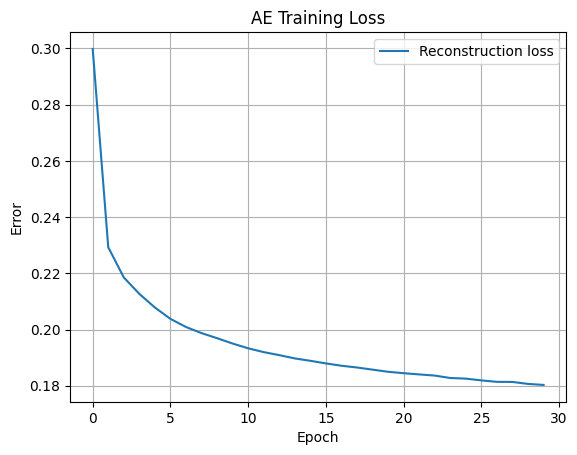

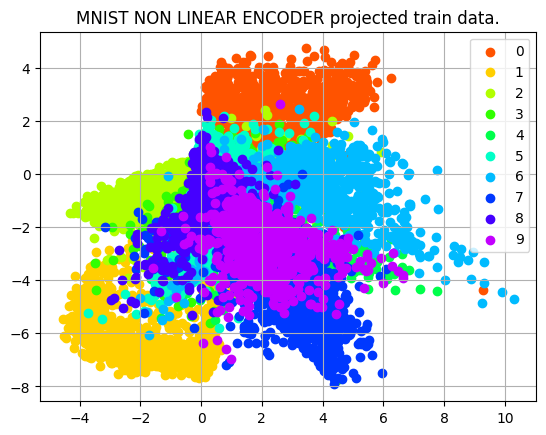

In [6]:
### Your code goes here ###

def create_and_train_model(num_epochs=500):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = nn.MSELoss()
    model = MLP_AE().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Lists to hold loss across epochs
    loss_train_ae = []
    for epoch in tqdm(range(num_epochs)):
        loss_epoch = 0
        loss_ae_epoch = 0

        for data in trainloader:
            # Batch loss for updating the model
            loss = 0
            optimizer.zero_grad()
            img, labels = data
            img = img.view(img.size(0), -1).to(device)
            labels = labels.to(device)
            recon = model(img)

            # Reconstruction loss
            loss_ae_batch = criterion(recon, img)
            loss += loss_ae_batch
            loss_ae_epoch += loss_ae_batch.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()

        # Record losses
        loss_train_ae.append(loss_ae_epoch / len(trainloader))
    return model, loss_train_ae
def plot_loss(model, loss_train_ae):
    # Evaluation mode
    model.eval()

    # Plot losses
    plt.plot(loss_train_ae, label="Reconstruction loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.title("AE Training Loss")
    plt.show()
    return model

def extract_emb_from_dataset(model, dataloader):
  model.eval()
  encoded_data = []
  labels_all = []
  for data in dataloader:
      img, labels = data
      img = img.view(img.size(0), -1)
      img = Variable(img).to(device)
      x_code = model.encoder(img)
      encoded_data.append(x_code.detach().cpu().numpy())
      labels_all.append(labels.cpu().numpy())
  X_coded = np.concatenate(encoded_data, axis=0)
  y_all = np.concatenate(labels_all, axis=0)
  return X_coded, y_all


model_ae, train_loss = create_and_train_model(num_epochs=30)
plot_loss(model_ae, train_loss)
X_code_ae, labels = extract_emb_from_dataset(model_ae, trainloader)
plot_projected_data(X_code_ae, labels, "MNIST NON LINEAR ENCODER projected train data.")


# EX3 Linear Autoencoder (15pts)
1. Follow the steps of EX2, but remove the nonlinear activation functions.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [7]:
class Linear_AE(nn.Module):
    def __init__(self):
      super(Linear_AE, self).__init__()
      self.code_size = 2
      self.encoder = nn.Sequential(nn.Linear(784, 128),
                                   nn.Linear(128, self.code_size))
      self.decoder = nn.Sequential(nn.Linear(self.code_size, 128),
                                   nn.Linear(128, 784))
    def forward(self,x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

  0%|          | 0/30 [00:00<?, ?it/s]

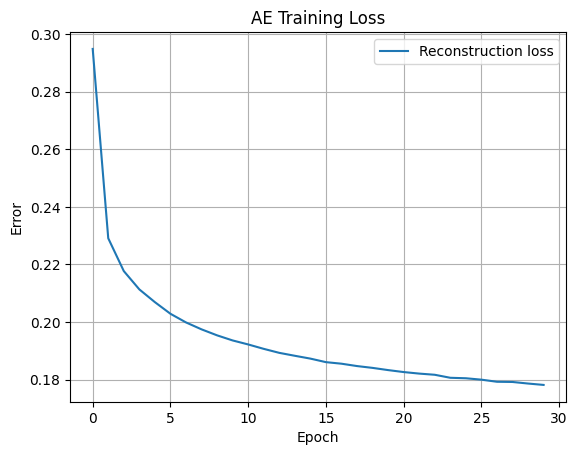

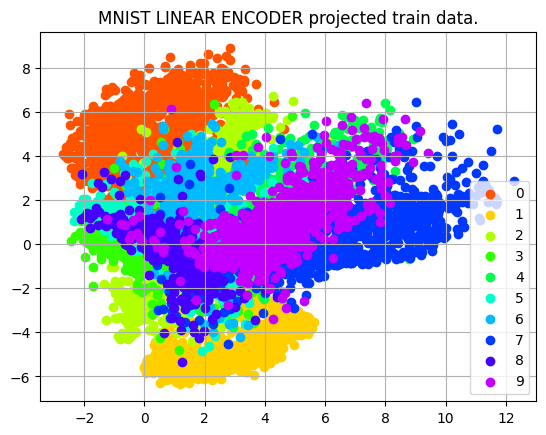

In [8]:
### Your code goes here ###
model_LinearAE, train_loss = create_and_train_model(num_epochs=30)
plot_loss(model_LinearAE, train_loss)
X_code_Linear_ae, labels_linear = extract_emb_from_dataset(model_LinearAE, trainloader)
plot_projected_data(X_code_Linear_ae, labels_linear, "MNIST LINEAR ENCODER projected train data.")

# EX 4 - Discussion (10pts)
1. Write a new plotting function and plot the results side-by-side using subplots.
2. Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?


**Ex4 Answers:**
2. The PCA projection (left) shows significant overlap between clusters of different labels, as it captures only linear patterns, limiting its ability to separate non-linear data. The non-linear encoder (middle) achieves distinct, well-separated clusters, demonstrating its strength in capturing complex, non-linear structures. The linear encoder (right) improves upon PCA by better separating clusters but does not match the separation quality of the non-linear encoder. another point of difference is the scale of the models.
Overall, PCA and Linear AE are a good choice for linear data, but for data set like MNIST it is preffered to use NONLinear AE.



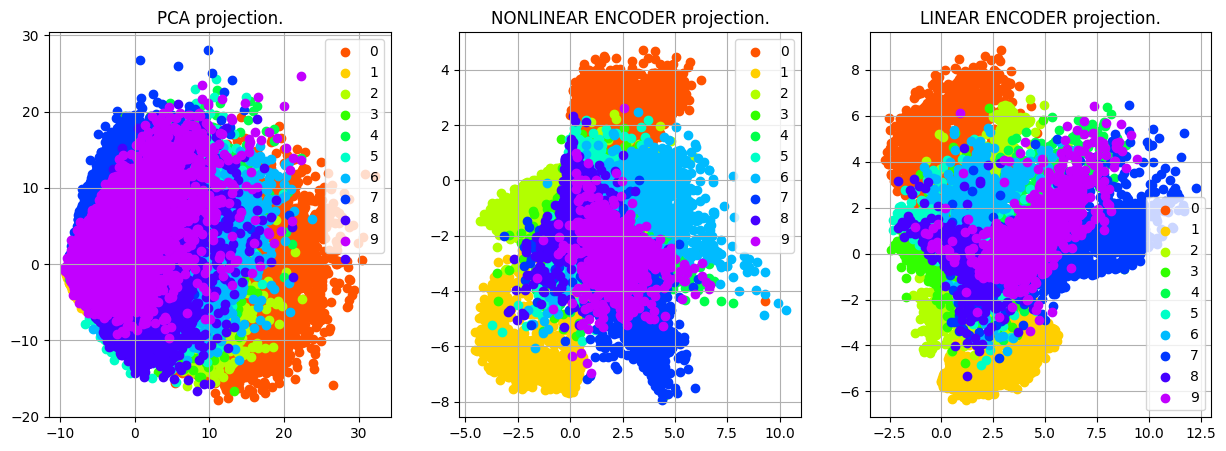

In [9]:
def plot_projected_data_side_by_side(X1, y1, X2, y2, X3, y3):
  plt.figure(figsize=(15,5))
  plt.subplot(131)
  plot_projected_data(X1, y1, "PCA projection.")
  plt.subplot(132)
  plot_projected_data(X2 ,y2, "NONLINEAR ENCODER projection.")
  plt.subplot(133)
  plot_projected_data(X3, y3, "LINEAR ENCODER projection.")

plot_projected_data_side_by_side(X_reduced, train_subset.dataset.targets.numpy(), X_code_ae, labels, X_code_Linear_ae, labels_linear)

# EX 5 - Denoising AE and Classification (50pts.)
In this section you will implement and train a denosing AE to clean corrupted MNIST images.
You are given a trained MLP model (from DL PS1) with ~94% test set accuracy on the cleaned images. Again, work with only 10k images (a subset of the train set).
Your tasks are as follows:
0. Load the mlp.pth file to your project (not google drive dir) and initiate the MLP model with the trained weights.
1. Compute the test set accuracy for the clean and corrupted datasets.
2. Implemented and train autoencoder to remove the noise.
3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
4. Compute the test set accuracy on the cleaned/denoised corrupted test set. Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

You **may not re-train** the classification network or train a new model for classification task.

There is **no need** to submit the trained model weights.

### Grading for this section:
```python
50pts = max(cleaned image accuracy + 10, 100)*0.5 #(i.e, accuracy >= 90% will give you a full grade).
```

You will also be evaluated on the quality of your code and apporach.

## Load trained model

In [10]:
# MLP classifier from DL PS1 - DO NOT CHANGE
mlp_clf = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<ipython-input-10-310ad3651e44>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<All keys matched successfully>

## Data and functions

In [11]:
# Noise function - DO NOT CHANGE
def add_gaussian_noise(images, mean=0.0, std=2):
    noise = torch.randn(images.size(), device = images.device) * std + mean
    noisy_images = images + noise
    return noisy_images


# Accuracy - DO NOT CHANGE
def compute_accuracy(model, testloader, denoise_model=None, add_noise=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Ensure images and labels are on the same device
            if add_noise:
                images = add_gaussian_noise(images).to(device)  # Move noisy images to the same device
            if denoise_model is not None:
                images = denoise_model(images.to(device))  # Ensure denoised images are on the same device
            images = images.view(images.shape[0], -1)  # Flatten images
            outputs = model(images)  # Pass through the model
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy




In [12]:
# Compute and print test accuracy for clean and corrupted images
mlp_clf.to(device)
clean_accuracy = compute_accuracy(mlp_clf, testloader, add_noise=False)
noisy_accuracy = compute_accuracy(mlp_clf, testloader, add_noise=True)
print(f"Clean Accuracy: {clean_accuracy:.2f}%")
print(f"Noisy Accuracy: {noisy_accuracy:.2f}%")

Clean Accuracy: 93.98%
Noisy Accuracy: 59.22%


In [29]:
### Your code goes here ###

class DenoisingAE(nn.Module):
    def __init__(self):
        super(DenoisingAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # (28x28 -> 28x28)
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.MaxPool2d(2, 2),# (28x28 -> 14x14)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (14x14 -> 14x14)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # (14x14 -> 7x7)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (7x7 -> 7x7)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# (7x7 -> 7x7)
            nn.ReLU()
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),  # Reduce depth to 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 32, kernel_size=1),  # Reduce depth to 32
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (7x7 -> 14x14)
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (14x14 -> 28x28)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  # (28x28 -> 28x28)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1) # Final layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

autoencoder = DenoisingAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.75)


epochs = 200
for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0
    for images, _ in trainloader:
        images = images.to(device)
        noisy_images = add_gaussian_noise(images).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_loss = train_loss / len(trainloader)
    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(trainloader):.4f}")


Epoch [1/200], Loss: 0.1995
Epoch [2/200], Loss: 0.1183
Epoch [3/200], Loss: 0.1119
Epoch [4/200], Loss: 0.1096
Epoch [5/200], Loss: 0.1069
Epoch [6/200], Loss: 0.1059
Epoch [7/200], Loss: 0.1037
Epoch [8/200], Loss: 0.1029
Epoch [9/200], Loss: 0.1018
Epoch [10/200], Loss: 0.1008
Epoch [11/200], Loss: 0.0999
Epoch [12/200], Loss: 0.0995
Epoch [13/200], Loss: 0.0990
Epoch [14/200], Loss: 0.0982
Epoch [15/200], Loss: 0.0981
Epoch [16/200], Loss: 0.0971
Epoch [17/200], Loss: 0.0968
Epoch [18/200], Loss: 0.0962
Epoch [19/200], Loss: 0.0960
Epoch [20/200], Loss: 0.0959
Epoch [21/200], Loss: 0.0957
Epoch [22/200], Loss: 0.0951
Epoch [23/200], Loss: 0.0951
Epoch [24/200], Loss: 0.0942
Epoch [25/200], Loss: 0.0938
Epoch [26/200], Loss: 0.0942
Epoch [27/200], Loss: 0.0936
Epoch [28/200], Loss: 0.0938
Epoch [29/200], Loss: 0.0936
Epoch [30/200], Loss: 0.0933
Epoch [31/200], Loss: 0.0930
Epoch [32/200], Loss: 0.0925
Epoch [33/200], Loss: 0.0923
Epoch [34/200], Loss: 0.0928
Epoch [35/200], Loss: 0

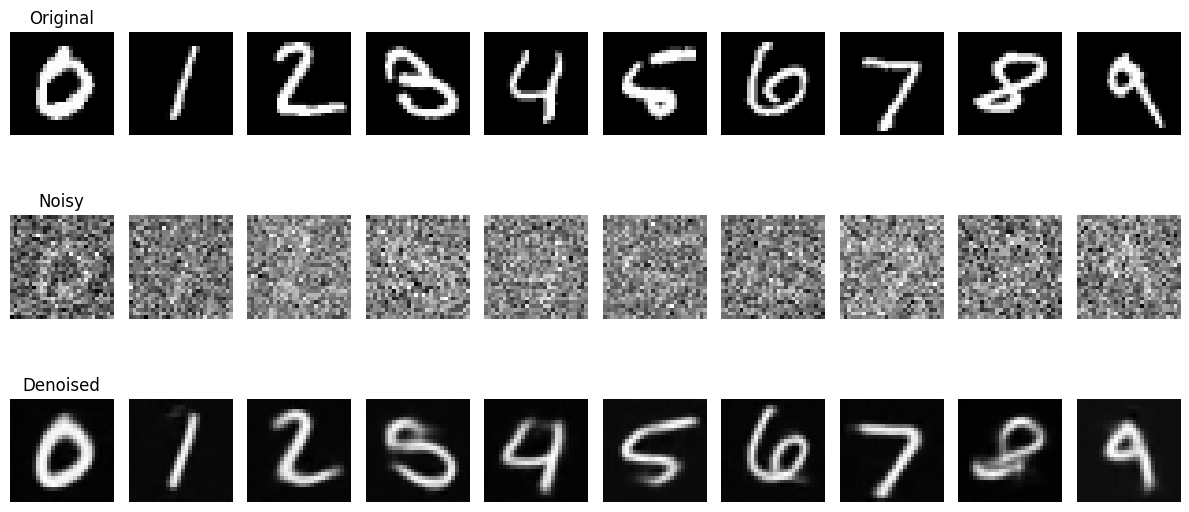

In [32]:
def visualize_results(autoencoder, testloader, device):
    autoencoder.eval()  # Set autoencoder to evaluation mode

    # Prepare a dictionary to hold one image per label
    label_images = {}

    # Iterate through the test loader to find one image per label
    for images, labels in testloader:
        for img, label in zip(images, labels):
            if label.item() not in label_images:  # Check if label is already added
                label_images[label.item()] = img
            if len(label_images) == 10:  # Stop once all labels are found
                break
        if len(label_images) == 10:
            break

    # Prepare images and labels
    images = torch.stack([label_images[i] for i in range(10)]).to(device)
    noisy_images = add_gaussian_noise(images)  # Add noise
    with torch.no_grad():
        denoised_images = autoencoder(noisy_images)

    # Plot the results
    plt.figure(figsize=(12, 6))
    for i in range(10):
        ax = plt.subplot(3, 10, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title('Original')

        ax = plt.subplot(3, 10, i + 11)
        plt.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title('Noisy')

        ax = plt.subplot(3, 10, i + 21)
        plt.imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            ax.set_title('Denoised')

    plt.tight_layout()
    plt.show()

visualize_results(autoencoder, testloader, device)

In [34]:
def compute_accuracy_with_denoising(mlp_clf, testloader, autoencoder, device, num_trials=5):
    autoencoder.eval()
    mlp_clf.eval()

    accuracies = []

    for trial in range(num_trials):
        correct = 0
        total = 0

        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            noisy_images = add_gaussian_noise(images)
            with torch.no_grad():
                denoised_images = autoencoder(noisy_images)
                denoised_images = denoised_images.view(denoised_images.size(0), -1)  # Flatten to [batch_size, 784]
                outputs = mlp_clf(denoised_images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = (correct / total) * 100
        accuracies.append(accuracy)
        print(f"Trial {trial + 1}/{num_trials}: Accuracy = {accuracy:.4f}")

    average_accuracy = sum(accuracies) / num_trials
    print(f"\nAverage Accuracy over {num_trials} trials: {average_accuracy:.4f}")

compute_accuracy_with_denoising(
    mlp_clf=mlp_clf,
    testloader=testloader,
    autoencoder=autoencoder,
    device=device,
    num_trials=5)

Trial 1/5: Accuracy = 86.7800
Trial 2/5: Accuracy = 86.4900
Trial 3/5: Accuracy = 86.9000
Trial 4/5: Accuracy = 86.4900
Trial 5/5: Accuracy = 86.7900

Average Accuracy over 5 trials: 86.6900
